# Exercise 6

<img src="./images/06.png" alt="exercise1" width=700>

**I couldn't download the specified dataset, so I decided to complete this exercise using a different dataset. I used the Mosquito-on-human-skin dataset, which is accessible [here](https://data.mendeley.com/datasets/zw4p9kj6nt/2). This dataset is structured as follows: it contains three main folders: Train, Test, and Pred. Each of these folders includes subfolders named according to the labels of the images they contain.**

<img src="./images/06_1.png" width=500>

#### None Lazy Approach

In [ ]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


class TrainDtaset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.path = path
        self.paths = []
        self.labels =[]
        self.path_class = [pth_train for pth_train in self.path.rglob('*') if pth_train.is_dir()]
        self.folder_class = {path_cls.name: cls for cls, path_cls in enumerate(self.path_class)}
        for pth_class in self.path_class:
            for path_image in pth_class.rglob('*'):
                self.paths.append(path_image)
                self.labels.append(self.folder_class[pth_class.name])

    def __getitem__(self, index):

        image = Image.open(self.paths[index]).convert('RGB')
        transform = transforms.Compose(
                [   transforms.Resize((224, 224)),
                    transforms.ToTensor()
                ]
                )
        image_tensor = transform(image)
        label_tensor = torch.tensor(self.labels[index], dtype=torch.int64)
        return image_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

In [ ]:
from pathlib import Path
path = Path('./data_splitting/Test')
train_dataset = TrainDtaset(path)
print(len(train_dataset))
print(train_dataset[-1])

1799
(tensor([[[0.6549, 0.6588, 0.6549,  ..., 0.8157, 0.8118, 0.8118],
         [0.6471, 0.6510, 0.6510,  ..., 0.8196, 0.8196, 0.8196],
         [0.6510, 0.6510, 0.6471,  ..., 0.8157, 0.8157, 0.8157],
         ...,
         [0.6784, 0.6667, 0.6510,  ..., 0.7490, 0.7490, 0.7490],
         [0.6824, 0.6745, 0.6588,  ..., 0.7529, 0.7529, 0.7569],
         [0.6902, 0.6784, 0.6667,  ..., 0.7569, 0.7529, 0.7608]],

        [[0.5569, 0.5608, 0.5569,  ..., 0.7333, 0.7294, 0.7294],
         [0.5490, 0.5529, 0.5529,  ..., 0.7373, 0.7373, 0.7373],
         [0.5529, 0.5529, 0.5490,  ..., 0.7333, 0.7333, 0.7333],
         ...,
         [0.5569, 0.5451, 0.5294,  ..., 0.6510, 0.6510, 0.6510],
         [0.5569, 0.5490, 0.5294,  ..., 0.6510, 0.6510, 0.6549],
         [0.5647, 0.5529, 0.5373,  ..., 0.6549, 0.6510, 0.6588]],

        [[0.4784, 0.4824, 0.4784,  ..., 0.6667, 0.6627, 0.6627],
         [0.4706, 0.4745, 0.4745,  ..., 0.6706, 0.6706, 0.6706],
         [0.4667, 0.4667, 0.4627,  ..., 0.6667, 0.66

#### Lazy Approach
To make TrainDataset class use lazy loading in the __getitem__ method, we can modify it so that it doesn't load all the image paths and labels upfront in the __init__ method. Instead, we'll load the image names for each class only when they are needed during iteration. 

4200
torch.Size([3, 224, 224]) tensor(0)


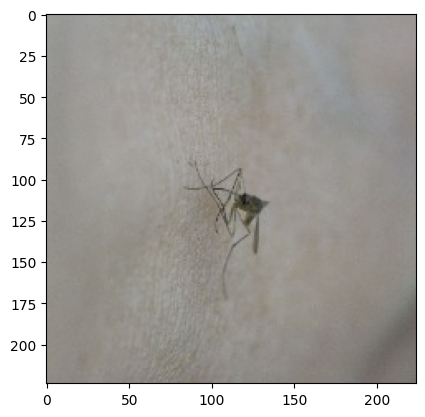

In [ ]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import bisect



class TrainDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.path = Path(path)
        self.class_folders = sorted([p for p in self.path.iterdir() if p.is_dir()])
        self.class_to_idx = {p.name: idx for idx, p in enumerate(self.class_folders)}
        self.class_image_counts = []
        self.class_cumulative_counts = []
        total_images = 0
        for class_folder in self.class_folders:
            # Count the number of images in each class without storing their paths
            class_image_count = len([1 for _ in class_folder.iterdir() if _.is_file()])
            self.class_image_counts.append(class_image_count)
            total_images += class_image_count
            self.class_cumulative_counts.append(total_images)
        self.total_images = total_images
        # Initialize a list to store image names per class, but load them lazily
        self.class_image_names = [None] * len(self.class_folders)

    def __len__(self):
        return self.total_images

    def __getitem__(self, index):
        # Determine which class the index belongs to
        class_idx = bisect.bisect_right(self.class_cumulative_counts, index)
        if class_idx == 0:
            image_idx_in_class = index
        else:
            image_idx_in_class = index - self.class_cumulative_counts[class_idx - 1]

        # Lazily load image names for the class if not already loaded
        if self.class_image_names[class_idx] is None:
            class_folder = self.class_folders[class_idx]
            image_names = sorted([p.name for p in class_folder.iterdir() if p.is_file()])
            self.class_image_names[class_idx] = image_names
        else:
            image_names = self.class_image_names[class_idx]

        image_name = image_names[image_idx_in_class]
        image_path = self.class_folders[class_idx] / image_name
        
        # Load and process the image
        image = Image.open(image_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        image_tensor = transform(image)
        label_tensor = torch.tensor(class_idx, dtype=torch.int64)
        return image_tensor, label_tensor


path = './data_splitting/Train'
dataset = TrainDataset(path)
print(len(dataset))
image_tensor, label_tensor = dataset[0]  # Load the first image and label
print(image_tensor.shape, label_tensor)
plt.imshow(image_tensor.permute(1, 2, 0))  # Permute to convert to (H, W, C) format for matplotlib


Explanation:
- Lazy Loading of Image Names:
  - In the __init__ method, we avoid loading all the image paths upfront. Instead, we initialize `self.class_image_names` as a list of None values.
  - In the __getitem__ method, we check if the image names for the required class have been loaded. If not, we load them and store them in `self.class_image_names`. This way, image names are loaded only when needed.

- Efficient Indexing:
  - We use the `bisect` module to efficiently determine the class index for a given dataset index.
  - By maintaining `self.class_cumulative_counts`, we can map any dataset index to the corresponding class and image index within that class.

- Avoiding Upfront Path Storage:
  - By not storing all image paths and labels upfront, we reduce memory usage and potentially speed up the dataset initialization, especially for large datasets.

This modification ensures that our dataset class now loads image paths lazily during iteration, which is especially useful when working with very large datasets.